In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # regression에서는 사용 편함.

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, Model, layers

SEED = 511
np.random.seed(SEED)

<ipython-input-1-93a8df37e760>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
num_data = 3000
x1 = np.random.rand(num_data)
x2 = np.random.rand(num_data)
x3 = np.random.rand(num_data)
x4 = np.random.rand(num_data)

X = np.array([x1, x2, x3, x4]).T
y = x1 + x2**2 + 10*x3 + np.log(x4)
y = y.reshape(-1, 1)

print(X.shape)
print(y.shape)

(3000, 4)
(3000, 1)


In [12]:
xscaler = MinMaxScaler()
yscaler = MinMaxScaler()

xscaler.fit(X)
scaled_x = xscaler.transform(X)

yscaler.fit(y)
scaled_y = yscaler.transform(y)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=SEED)
xtrain = tf.constant(xtrain, dtype=tf.float32)
xtest = tf.constant(xtest, dtype=tf.float32)
ytrain = tf.constant(ytrain, dtype=tf.float32)
ytest = tf.constant(ytest, dtype=tf.float32)

In [4]:
train_dataset = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
train_dataset = train_dataset.shuffle(buffer_size=len(xtrain), seed=SEED).batch(batch_size=64)

test_dataset = tf.data.Dataset.from_tensor_slices((xtest, ytest))
test_dataset = test_dataset.shuffle(buffer_size=len(ytrain), seed=SEED).batch(batch_size=64)

In [5]:
class ANN(Model):
    def __init__(self,):
        super(ANN, self).__init__()
        self.fc1 = layers.Dense(units=64, input_dim=xtrain.shape[1], activation=tf.nn.gelu)
        self.dropout1 = layers.Dropout(0.5)
        self.fc2 = layers.Dense(units=64, activation=tf.nn.gelu)
        self.dropout2 = layers.Dropout(0.5)
        self.out = layers.Dense(units=ytrain.shape[1], activation=None)

    def call(self, x, is_training=False):
        x = self.fc1(x)
        if is_training:
            x = self.dropout1(x)
        x = self.fc2(x)
        if is_training:
            x = self.dropout2(x)
        x = self.out(x)
        return x

In [6]:
loss_fn = keras.losses.MeanSquaredError()

optimizer = optimizers.Adam(learning_rate=0.001)

model = ANN()

In [7]:
losslist = []

with tf.device('/GPU:0'):
    for epoch in range(1, 800+1):
        total_loss = 0.0
        num_batches = int(0)

        for x, y_true in train_dataset:
            with tf.GradientTape() as tape:
                y_pred = model(x, is_training=True)
                loss = loss_fn(y_true, y_pred)
                total_loss += loss

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            num_batches += 1

        losslist.append( total_loss/num_batches )

        if epoch % 2 == 0:
            print(f"[Epoch]: {epoch}/800,  [Loss]: {np.round(total_loss / num_batches, 3)}")

[Epoch]: 2/800,  [Loss]: 7.747000217437744
[Epoch]: 4/800,  [Loss]: 2.385999917984009
[Epoch]: 6/800,  [Loss]: 0.5809999704360962
[Epoch]: 8/800,  [Loss]: 0.41200000047683716
[Epoch]: 10/800,  [Loss]: 0.38199999928474426
[Epoch]: 12/800,  [Loss]: 0.367000013589859
[Epoch]: 14/800,  [Loss]: 0.35600000619888306
[Epoch]: 16/800,  [Loss]: 0.34299999475479126
[Epoch]: 18/800,  [Loss]: 0.33500000834465027
[Epoch]: 20/800,  [Loss]: 0.3310000002384186
[Epoch]: 22/800,  [Loss]: 0.3149999976158142
[Epoch]: 24/800,  [Loss]: 0.2980000078678131
[Epoch]: 26/800,  [Loss]: 0.2919999957084656
[Epoch]: 28/800,  [Loss]: 0.2770000100135803
[Epoch]: 30/800,  [Loss]: 0.2590000033378601
[Epoch]: 32/800,  [Loss]: 0.2460000067949295
[Epoch]: 34/800,  [Loss]: 0.22300000488758087
[Epoch]: 36/800,  [Loss]: 0.20600000023841858
[Epoch]: 38/800,  [Loss]: 0.18199999630451202
[Epoch]: 40/800,  [Loss]: 0.15600000321865082
[Epoch]: 42/800,  [Loss]: 0.13699999451637268
[Epoch]: 44/800,  [Loss]: 0.12099999934434891
[Epoch

In [10]:
total_loss = 0.0
num_batches = 0
predlist= []

for x, y_true in test_dataset:
    y_pred = model(x, is_training=False)  # 평가 모드에서는 is_training=False
    loss = loss_fn(y_true, y_pred)
    total_loss += loss
    num_batches += 1
    predlist += y_pred.numpy().ravel().tolist()

avg_loss = np.round(total_loss / num_batches, 4)
print(f'[Avg_Loss]: {avg_loss}')

[Avg_Loss]: 0.023600000888109207


In [11]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 4.0 MB/s eta 0:00:00


In [41]:
import shap

explainer = shap.KernelExplainer(model.predict, xtrain.numpy())
shap_values = explainer.shap_values(xtest.numpy()[0, :].reshape(1, -1))
print(shap_values)

75/75 [==============================] - 0s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1050/1050 [==============================] - 2s 2ms/step
[array([[ 0.15208316,  0.23087082, -4.31642542,  0.26546765]])]


In [42]:
kane = tf.constant( xtest[0, :].numpy().reshape(1, -1) )
model(kane, is_training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0373502]], dtype=float32)>

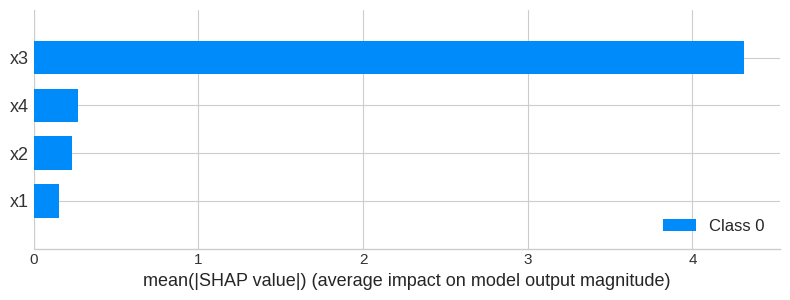

In [43]:
shap.summary_plot(shap_values, kane, feature_names=['x1', 'x2', 'x3', 'x4'])
